In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import os
os.chdir('drive/My Drive/colab_notebooks/pose_estimation')

In [ ]:
!nvidia-smi

## Imports

In [2]:
import json
import requests
import zipfile
import torch
import os
import numpy as np
from torch.utils import data
from torchvision import transforms
from PIL import Image
from io import BytesIO
from collections import OrderedDict
from generate_cmap_paf import generate_cmap, generate_paf, generate_topology_independent_paf, annotations_to_connections, annotations_to_peaks
from pose_datasets import BodyAndFeetConfig

In [3]:
def generate_cmap_pinpoint(counts: torch.Tensor, peaks: torch.Tensor, height, width, amplify_output=False):
    C = peaks.size(0)  # number of part types
    M = peaks.size(1)  # max number of parts per type
    H = height
    W = width

    cmap = torch.zeros(C, H, W)

    for c in range(C):

        count = int(counts[c])
        for p in range(count):
            i_pos = float(peaks[c][p][0] * H)
            j_pos = float(peaks[c][p][1] * W)

            # find point's central location
            i_center = int(np.round(i_pos))
            j_center = int(np.round(j_pos))

            i_pos_rel = i_pos - i_center
            j_pos_rel = j_pos - j_center

            # add x and y components
            left_x = 0.5 - j_pos_rel
            right_x = 0.5 + j_pos_rel
            top_y = 0.5 - i_pos_rel
            bottom_y = 0.5 + i_pos_rel

            max_val = 0

            if check_bounds(j_center - 1, i_center - 1, H, W):
                cmap[c, i_center - 1, j_center - 1] = top_y * left_x
                max_val = max(max_val, top_y * left_x)
            if check_bounds(j_center - 1, i_center, H, W):
                cmap[c, i_center, j_center - 1] = bottom_y * left_x
                max_val = max(max_val, bottom_y * left_x)
            if check_bounds(j_center, i_center, H, W):
                cmap[c, i_center, j_center] = bottom_y * right_x
                max_val = max(max_val, bottom_y * right_x)
            if check_bounds(j_center, i_center - 1, H, W):
                cmap[c, i_center - 1, j_center] = top_y * right_x
                max_val = max(max_val, top_y * right_x)

            if amplify_output:
                # make max value to be 1
                if check_bounds(j_center - 1, i_center - 1, H, W):
                    cmap[c, i_center - 1, j_center - 1] /= max_val if max_val != 0 else 0
                if check_bounds(j_center - 1, i_center, H, W):
                    cmap[c, i_center, j_center - 1] /= max_val if max_val != 0 else 0
                if check_bounds(j_center, i_center, H, W):
                    cmap[c, i_center, j_center] /= max_val if max_val != 0 else 0
                if check_bounds(j_center, i_center - 1, H, W):
                    cmap[c, i_center - 1, j_center] /= max_val if max_val != 0 else 0

    return cmap

def check_bounds(x, y, H, W):
    return x < W and x >= 0 and y < H and y >= 0

tensor(0.3852)
tensor(0.3182)


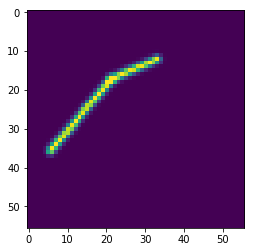

In [48]:
import matplotlib.pyplot as plt

out_size = 56

config = BodyAndFeetConfig(out_size, out_size)

peaks = torch.zeros(config.num_parts, 100, 2)
counts = torch.ones(config.num_parts)

for i in range(config.num_parts):
    peaks[i][0][0] = np.random.rand()
    peaks[i][0][1] = np.random.rand()

stdev = 1
window = 5 * stdev
cmap = generate_cmap_pinpoint(counts, peaks, out_size, out_size, amplify_output=True)

connections = torch.zeros(config.num_links, 2, 100) - 1

for i in range(config.num_links):
    connections[i][0][0] = 0
    connections[i][1][0] = 0

paf = generate_topology_independent_paf(connections, config.topology, counts, peaks, 56, 56, stdev)

yy, xx = torch.meshgrid(torch.arange(out_size), torch.arange(out_size))
yy = yy + 0.5
xx = xx + 0.5
print(torch.sum(xx * cmap[0]) / torch.sum(cmap[0]) / out_size)
print(torch.sum(yy * cmap[0]) / torch.sum(cmap[0]) / out_size)

plt.imshow(paf[0], vmin=0, vmax=1)
plt.show()